In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

plt.style.use('ggplot')
sns.set(color_codes=True)

# data loading 

In [3]:
df = pd.read_csv("../NEO-Hazard-Predictor/data/raw/neo.csv")

# Exploratory data analysis and data cleaning

There is no one method or common methods in order to perform EDA but we will use common methods and plots that would be used in the EDA process.

first the df.head() to show the first 5 samples of the data

In [4]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [5]:
df.columns

Index(['id', 'name', 'est_diameter_min', 'est_diameter_max',
       'relative_velocity', 'miss_distance', 'orbiting_body', 'sentry_object',
       'absolute_magnitude', 'hazardous'],
      dtype='object')

the next step seems clear as some of the columns in the data set don't make any sense to keep like the id and name of the planet and orbiting body as there is no variance in it

In [6]:
df = df.drop(['id', 'name', 'orbiting_body'], axis=1)

most of the data-sets have many missing values so make sure to always check for them as it can easily disturb the model and reduce its accuracy

In [7]:
print(df.isnull().sum())
# as u can see this dataset is already clean 

est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
sentry_object         0
absolute_magnitude    0
hazardous             0
dtype: int64


``` text
Here we check for the datatypes as sometimes the integers are stored as strings and in this can we will need to convert them back
```

In [8]:
df.dtypes
# but look at the sentry_object and the hazardous column they are stored as boolean values so we will need to convert them into integer value

est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
sentry_object            bool
absolute_magnitude    float64
hazardous                bool
dtype: object

In [9]:
df['hazardous'] = df['hazardous'].astype(int)
df['sentry_object'] = df['sentry_object'].astype(int)

# feature engineering

``` text
now first look at the 'est_diameter_min' 'est_diameter_max' columns. 
keeping both is redundant.
so the fit solution is to get the avg of both. like this You just reduced dimensionality while keeping 100% of the value.
```

In [10]:
df["est_diameter_avg"] = df[['est_diameter_min', 'est_diameter_max']].mean(axis=1)
df = df.drop(df[['est_diameter_min', 'est_diameter_max']], axis=1)

In [11]:
df.head()

,relative_velocity,miss_distance,sentry_object,absolute_magnitude,hazardous,est_diameter_avg
0,13569.249224,5.483974e+07,0,16.73,0,1.938843
1,73588.726663,6.143813e+07,0,20.00,1,0.430073
2,114258.692129,4.979872e+07,0,17.83,0,1.168268
3,24764.303138,2.543497e+07,0,22.20,0,0.156150
4,42737.733765,4.627557e+07,0,20.09,1,0.412613


```text
we know we have to split the data into training and testing but when?

1. Row-Wise Operations (Safe to do BEFORE splitting):
Any operation performed on a single, isolated row (e.g., converting True to 1, or calculating avg_diameter by adding two features together). Because the math only looks at one asteroid at a time, it is mathematically impossible for the Test Data to accidentally influence the Training Data. Therefore, there is zero risk of data leakage, and it is safe to do before the split.

2. Column-Wise Operations (Must do AFTER splitting):
Any operation that requires calculating statistics across an entire column (e.g., Scaling, Mean Imputation, or Correlation Matrices). Because the math must look at every single row to find the average or variance, doing this before the split means the Test Data will secretly influence the math. To prevent this data leakage, we must split the data first, and only calculate these metrics on the Training set.
```

now that we are done with all the raw-wise operation we can split the data

In [12]:
# slicing the data into X and Y
X = df.drop(columns=['hazardous'])
y = df['hazardous']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

after splitting the data a correlation matrix is essential to find the relation between the features so and if the correlation is higher than "danger zone" of 0.85 the feature must be dropped

In [14]:
corr = X_train.corr()
corr

,relative_velocity,miss_distance,sentry_object,absolute_magnitude,est_diameter_avg
relative_velocity,1.000000,0.328770,NaN,-0.354877,0.211094
miss_distance,0.328770,1.000000,NaN,-0.265668,0.137386
sentry_object,NaN,NaN,NaN,NaN,NaN
absolute_magnitude,-0.354877,-0.265668,NaN,1.000000,-0.540780
est_diameter_avg,0.211094,0.137386,NaN,-0.540780,1.000000


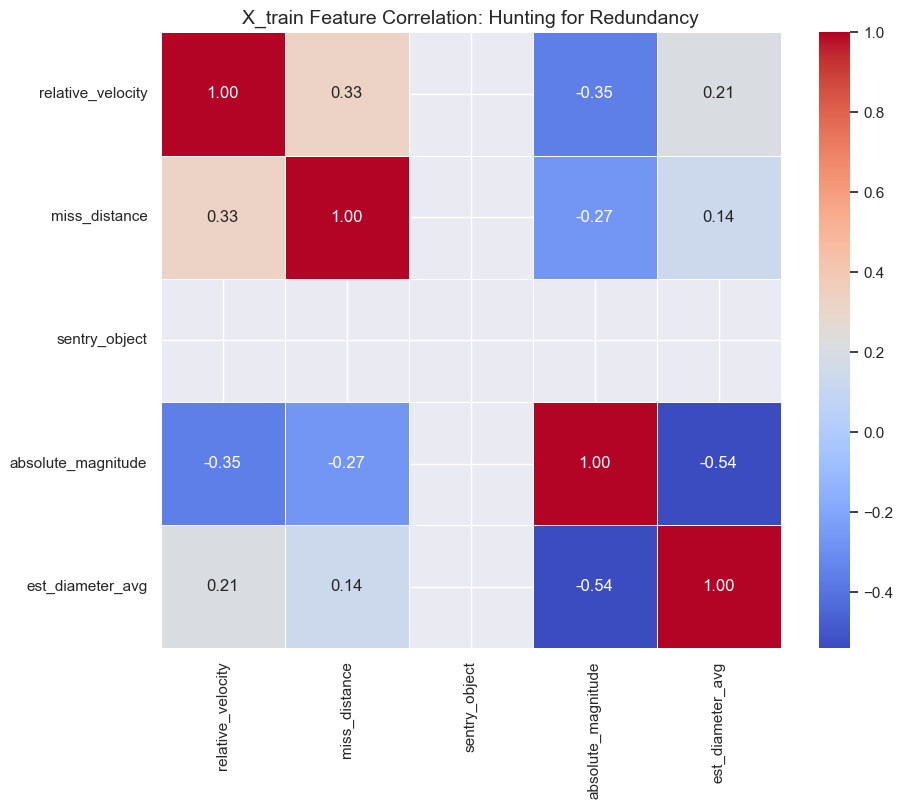

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("X_train Feature Correlation: Hunting for Redundancy", fontsize=14)
plt.show()

observe the correlation matrix and the heatmap we generated all the features dont even come close to the .85 so that is good. but observe that sentry_object feature it has no correlation which usually means it has no variance so it must be dropped

In [16]:
X_train = X_train.drop("sentry_object", axis=1)
# *critical*: dont forget to drop the same feature in the test data as well to keep them matched
X_test = X_test.drop("sentry_object", axis=1)

# preprocessing

In [17]:
X_train.describe()

,relative_velocity,miss_distance,absolute_magnitude,est_diameter_avg
count,72668.000000,7.266800e+04,72668.000000,72668.000000
mean,48056.341395,3.709139e+07,23.525409,0.207428
std,25257.037962,2.235471e+07,2.898315,0.507231
min,203.346433,6.745533e+03,9.230000,0.000985
25%,28632.338106,1.720310e+07,21.340000,0.031156
50%,44244.808278,3.789466e+07,23.700000,0.078260
75%,62906.940878,5.658472e+07,25.700000,0.232029
max,236990.128088,7.479865e+07,33.200000,61.311595


```text
Take a look at the data in your dataframe:
- miss_distance is measured in the tens of millions.
- est_diameter_avg is a tiny decimal like 0.43.
If we feed this raw data into a machine learning model, the math will naturally assume that miss_distance is the most important feature simply because the numbers are massive. It will completely ignore the size of the asteroid!
that is why scaling is a good abroach
```

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

hazardous
0    65596
1     7072
Name: count, dtype: int64


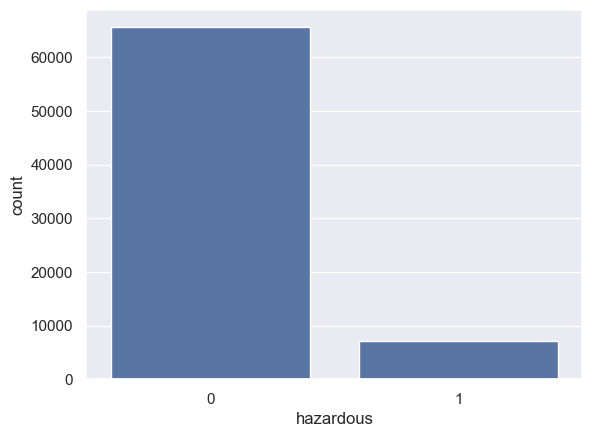

In [21]:
print(pd.Series(y_train).value_counts())
# a hist graph to view the imbalance in the data 
sns.countplot(x=y_train)
plt.show()

```text
look at that imbalance in the data that is almost 10:1 ratio 
there are many solutions to that problem but without diving into detail we will use SMOTE (over_sampler)
```

In [23]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)


hazardous
0    65596
1    65596
Name: count, dtype: int64


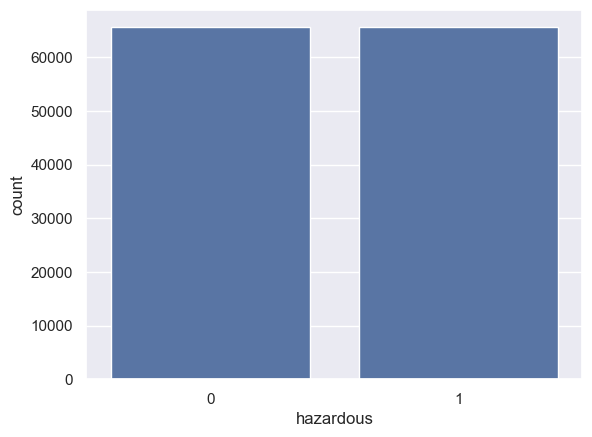

In [24]:
print(pd.Series(y_train).value_counts())
# a hist graph to view the imbalance in the data 
sns.countplot(x=y_train)
plt.show()

now have a look at that the data is no longer imbalanced